# Adobe stock and analyst data 

This notebook combines the Anachart data for analyst activity relating to Adobe (ADBE) stock with data for the actual stock prices (Close, High, and Low) for Adobe each day the stock market was open from 2011 to the present. It then cleans the data and analyzes it to determine if the analysts that have more experience with tech stocks make better predictions than those who don't. 

## Cleaning and analyzing the data 

### Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

### Read in the data and make large structural changes 

The data was downloaded as csv files, so we're able to read in the data using pandas read_csv to create a data frame with the Anachart (analyst) data and a data frame with the stock market data (obtained from Market Watch). We also fixed a spelling error in one of the columns of the analyst data and renamed the Date column from Market Watch to date so that the date columns in each data frame are identical and can be merged on. We also converted both of the date columns to the datetime type in python so it's easier to compare dates when needed later. We also make a data frame that only includes the date and Close columns from the stock data, as date is what we want to merge on and we want to add the Closing prices of each day to the analyst data. 

In [2]:
stock_data = pd.read_csv('adobe-stock-data.csv')
analyst_data = pd.read_csv('adobe-analyst-data.csv')
analyst_data = analyst_data.rename(columns={'analytst':'analyst'})
analyst_data['date'] = pd.to_datetime(analyst_data['date'])
stock_data = stock_data.rename(columns={'Date':'date'})
stock_data['date'] = pd.to_datetime(stock_data['date'])
stock_data_needed = stock_data[['date', 'Close']]

### Manually inputting the correct price targets when necessary 

Some of the rows in the analyst data had the price target before and after columns in the format price target before >> price target after, which we wouldn't be able to use in calculations in python since the >> symbol isn't numeric. Instead of disregarding those rows, we manually changed the values of each cell that had this issue to the correct number so they could still be included in analysis. 

In [3]:
analyst_data.at[27, 'price_target_after'] = 650
analyst_data.at[27, 'price_target_before'] = 720 
analyst_data.at[255, 'price_target_after'] = 520
analyst_data.at[255, 'price_target_before'] = 460
analyst_data.at[334, 'price_target_after'] = 570
analyst_data.at[334, 'price_target_before'] = 440
analyst_data.at[537, 'price_target_after'] = 358
analyst_data.at[537, 'price_target_before'] = 350

### Cleaning the data by dropping null values 

We converted the price target before and after columns to numeric data types (int or float) so that we could perform operations like means on them. This also means that any value in either of these columns that cannot be converted to a numeric data type will be given a value of NaN. We then make a cleaned data frame that drops any rows which have no value in the price target after column, as this column is the one we're performing operations with. 

In [4]:
analyst_data['price_target_before'] = pd.to_numeric(analyst_data['price_target_before'], errors='coerce')
analyst_data['price_target_after'] = pd.to_numeric(analyst_data['price_target_after'], errors='coerce')
analyst_data_cleaned = analyst_data.dropna(subset=['price_target_after'])

### Sorting the data frame by date 

For ease of comparison, we sort the data frame from most recent transaction to oldest and look at the first 5 rows to see the structure of the data frame. 

In [29]:
analyst_data_date_sort = analyst_data_cleaned.sort_values(by='date', ascending=False)

In [6]:
analyst_data_date_sort.head()

,date,company_Name,ticker,broker,analyst,rating_before,rating_after,price_target_before,price_target_after
728,2025-09-05,Adobe Systems Inc,ADBE,NaN,SAKET KALIA,Overweight,Overweight,460.0,460.0
329,2025-08-29,Adobe Systems Inc,ADBE,NaN,KARL KEIRSTEAD,Neutral,Neutral,400.0,400.0
228,2025-06-20,Adobe Systems Inc,ADBE,NaN,GIL LURIA,Buy,Buy,500.0,500.0
805,2025-06-16,Adobe Systems Inc,ADBE,CITI,TYLER RADKE,NEUTRAL,NEUTRAL,NaN,450.0
244,2025-06-13,Adobe Systems Inc,ADBE,MIZUHO,GREGG MOSKOWITZ,OUTPERFORM,OUTPERFORM,575.0,530.0


### Adding the closing price of Adobe stock on a given day 

To see how ambitious each price target was (how different it was from the current price of the stock when submitted), we want to add a column to the analyst data frame of the closing price of each stock on the day that the price target was submitted. To do this, we perform an inner merge on the analyst data and the data frame of the selected columns of the stock data. We use an inner merge because since comparing the price target to the closing price is going to be a central part of our analysis, both values need to be present. We merge these on the date column, as that's the common column that allows us to compare the two data frames. We also look at the first 5 rows of the new data frame to ensure that the merge happened as desired. 

In [30]:
adobe_data = pd.merge(left=analyst_data_date_sort, right=stock_data_needed, on='date', how='inner')

In [8]:
adobe_data.head()

,date,company_Name,ticker,broker,analyst,rating_before,rating_after,price_target_before,price_target_after,Close
0,2025-09-05,Adobe Systems Inc,ADBE,NaN,SAKET KALIA,Overweight,Overweight,460.0,460.0,348.97
1,2025-08-29,Adobe Systems Inc,ADBE,NaN,KARL KEIRSTEAD,Neutral,Neutral,400.0,400.0,356.70
2,2025-06-20,Adobe Systems Inc,ADBE,NaN,GIL LURIA,Buy,Buy,500.0,500.0,376.92
3,2025-06-16,Adobe Systems Inc,ADBE,CITI,TYLER RADKE,NEUTRAL,NEUTRAL,NaN,450.0,401.73
4,2025-06-13,Adobe Systems Inc,ADBE,MIZUHO,GREGG MOSKOWITZ,OUTPERFORM,OUTPERFORM,575.0,530.0,391.68


### Making a function that adds a column with the number of days (that the stock market was open) that it took each price target to be hit 

This function compares the price target of each row in the analyst data frame to the stock data frame to see how many days the stock market was open that it took for each price target to be reached. First, it ensures that the stock data is sorted by date so that it's easy to determine which rows are from after each price target was submitted. Then, it has another function inside that will compute how many days it takes for the price target to be reached for a given row. It does this by setting the start date (when the price target was submitted) and the price target (using price target after) for the row. Then, it indexes the stock data to only include days after the start date. If there's no days after the start date, the function will return a null value. As long as there's at least one day of data after the start date, the function will compare the price target to the closing date of the stock that day. If the price target was higher than the stock, then the function will find the days after the price target where the high value of the stock was at or above the price target and put them in a data frame. We use the high values as most days the high value is higher than the closing, so if we only looked at the closing price then it would seem like the price targets took longer to hit than they did. If the price target isn't higher than the closing price, then the function will do the same process as stated above, but it looks at the low values of the stock. If no days are found where the price target is hit, then the function will return a null value. Next, the function finds the date that the price target was hit by extracting the date value from the first row of the data frame with days where the price target was hit. Then, it returns the length of the future stocks data frame when the date is less than or equal to the hit date. This will be the number of days that the stock market was open since the price target was submitted until the price target was reached. Finally, the function adds another column (days_to_target) to the analyst data that was inputted, by applying the compute days function along axis 1, meaning that it runs the compute days function for every row in the data frame. It also returns this updated data frame with the new column. We then call the function on our data and look at the last 5 rows to check if the function worked properly. 

In [9]:
def days_to_hit_target(analyst_data, stock_data):
    stock_data = stock_data.sort_values("date")

    def compute_days(row):
        start_date = row["date"]
        target = row["price_target_after"]

        future_stocks = stock_data[stock_data["date"] > start_date].sort_values("date")

        if future_stocks.empty:
            return np.nan

        if target >= row["Close"]:
            hit = future_stocks[future_stocks["High"] >= target]

        else:
            hit = future_stocks[future_stocks["Low"] <= target]

        if hit.empty:
            return np.nan

        hit_date = hit.iloc[0]["date"]
        return len(future_stocks[future_stocks["date"] <= hit_date])

    analyst_data["days_to_target"] = analyst_data.apply(compute_days, axis=1)
    return analyst_data


In [10]:
days_to_hit_target(adobe_data, stock_data).tail()

,date,company_Name,ticker,broker,analyst,rating_before,rating_after,price_target_before,price_target_after,Close,days_to_target
779,2013-09-18,Adobe Systems Inc,ADBE,DEUTSCHE BANK,NANDAN AMLADI,,BUY,52.0,58.0,52.58,61.0
780,2013-06-19,Adobe Systems Inc,ADBE,DEUTSCHE BANK,NANDAN AMLADI,BUY,BUY,50.0,52.0,45.78,63.0
781,2013-03-20,Adobe Systems Inc,ADBE,NaN,MATTHEW HEDBERG,Outperform,Outperform,52.0,52.0,42.46,126.0
782,2012-12-14,Adobe Systems Inc,ADBE,NaN,MATTHEW HEDBERG,Outperform,Outperform,42.0,42.0,37.56,64.0
783,2012-12-14,Adobe Systems Inc,ADBE,JMP,PATRICK WALRAVENS,OUTPERFORM,UNDERPERFORM,NaN,42.0,37.56,64.0


### Adding a column with the difference in price target to the main data frame 

We wanted to see the difference in the price target and the closing price of the stock on the day it was submitted to see how ambitious of a price target it was. To do this, we add a column to the data frame that's the absolute value of the price target after and Close columns. We use the absolute value as the predicting the stock to go up or down doesn't really impact how ambitious of a price target it was for our purposes. 

In [11]:
adobe_data['pt_close_difference'] = abs(adobe_data['price_target_after'] - adobe_data['Close'])
adobe_data.tail()

,date,company_Name,ticker,broker,analyst,rating_before,rating_after,price_target_before,price_target_after,Close,days_to_target,pt_close_difference
779,2013-09-18,Adobe Systems Inc,ADBE,DEUTSCHE BANK,NANDAN AMLADI,,BUY,52.0,58.0,52.58,61.0,5.42
780,2013-06-19,Adobe Systems Inc,ADBE,DEUTSCHE BANK,NANDAN AMLADI,BUY,BUY,50.0,52.0,45.78,63.0,6.22
781,2013-03-20,Adobe Systems Inc,ADBE,NaN,MATTHEW HEDBERG,Outperform,Outperform,52.0,52.0,42.46,126.0,9.54
782,2012-12-14,Adobe Systems Inc,ADBE,NaN,MATTHEW HEDBERG,Outperform,Outperform,42.0,42.0,37.56,64.0,4.44
783,2012-12-14,Adobe Systems Inc,ADBE,JMP,PATRICK WALRAVENS,OUTPERFORM,UNDERPERFORM,NaN,42.0,37.56,64.0,4.44


In [32]:
adobe_data.to_csv('analyst-data')

## Visualizations 

### Comparing the days until the price target was hit and the difference in price target and current stock price

To make our visualizations dealing with the days until the price target was hit, we want to drop the null values so that they don't skew our visualizations. 

The first visualization we make is a scatter plot with the days until the price target was hit on the x-axis and the difference in price target and current stock price on the y-axis. The hue of each point represents the analyst that submitted each price target. Some issues with this visualization are that there are too many points to draw any conclusions about certain analysts and that there are so many analysts that it's almost impossible to differentiate between the colors and tell exactly which analyst submitted each price target. 

In [12]:
adobe_data_no_nan = adobe_data.dropna(subset=['days_to_target'])

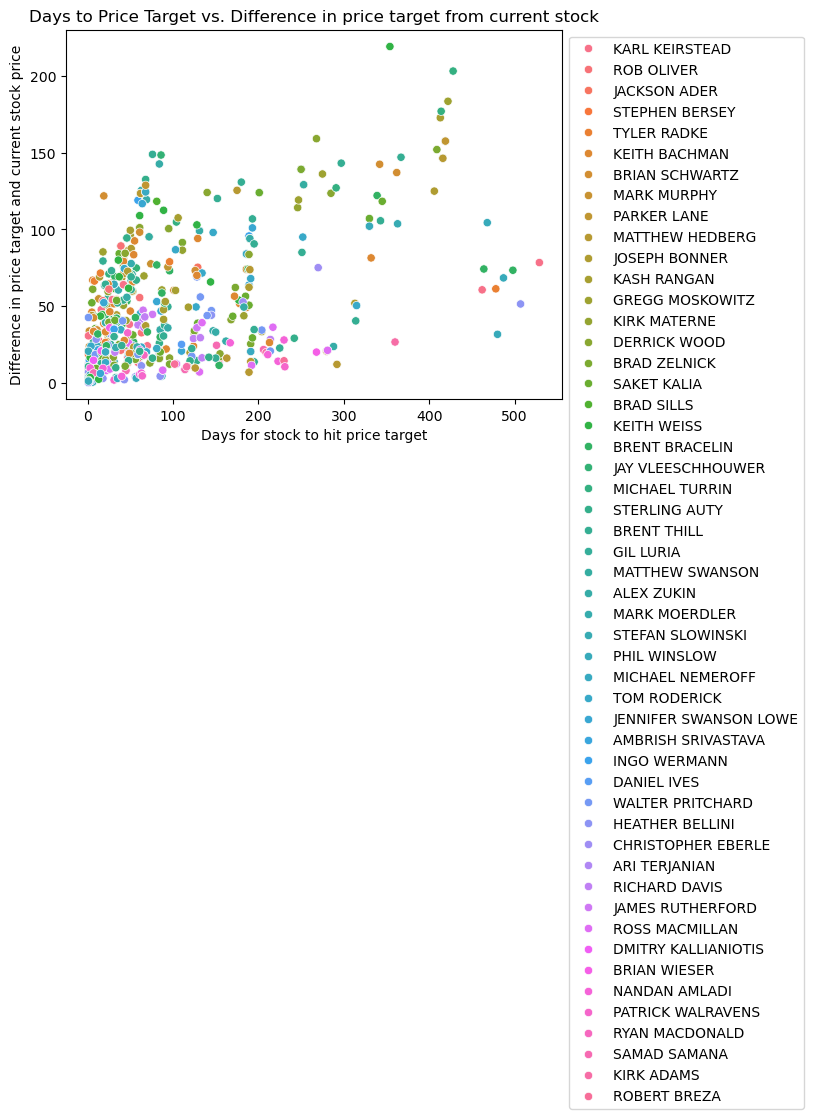

In [13]:
sns.scatterplot(adobe_data_no_nan, x='days_to_target', y='pt_close_difference', hue='analyst')
plt.title('Days to Price Target vs. Difference in price target from current stock')
plt.xlabel('Days for stock to hit price target')
plt.ylabel('Difference in price target and current stock price')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### Plotting averages 

To alleviate the issue of having too many points, we decided that working with the averages for each analyst would make it easier to interpret how good each analyst was. To do this, we made a separate data frame that groups the rows by analyst and then takes the mean of the days to target column for each analyst. Then, we added a column with the average difference in price target and stock price by grouping the main data frame by analyst and taking the mean of the pt close difference column for each one. Then, we made a scatter plot of the new data frame with the average days to price target on the x-axis and the average difference in price target and stock price on the y-axis. 

In [14]:
analyst_average = adobe_data_no_nan.groupby('analyst')['days_to_target'].mean().to_frame()
analyst_average['avg_difference'] = adobe_data_no_nan.groupby('analyst')['pt_close_difference'].mean()

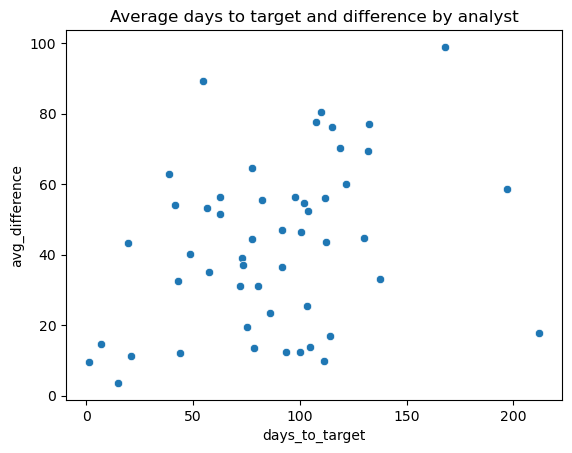

In [15]:
sns.scatterplot(analyst_average, x='days_to_target', y='avg_difference')
plt.title('Average days to target and difference by analyst')
plt.show()

We also thought that it would be interesting to add a trend line to this plot to see who's above average, so we used seaborn's regplot to do that so we got the same scatterplot as above, just with a trendline. 

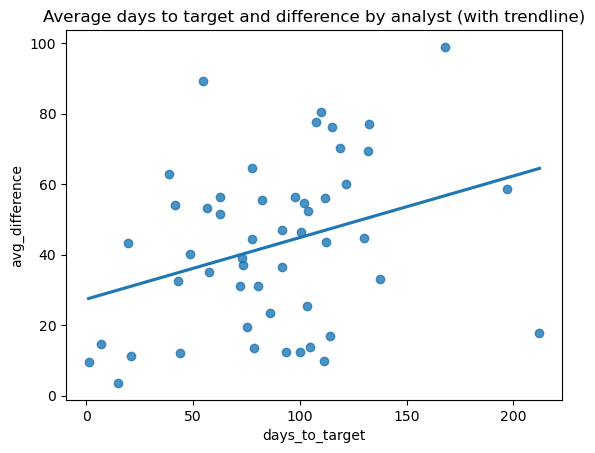

In [31]:
sns.regplot(analyst_average, x='days_to_target', y='avg_difference', ci=None)
plt.title('Average days to target and difference by analyst (with trendline)')
plt.show()

### Looking at price targets that were never reached

Although the average time taken to reach the price target and how ambitious it is are great indicators of how well an analyst is performing, we also want to look at how many of their price targets were never reached. To do this, we made another data frame with the counts of each price target that were never met per analyst. To account for some analysts making more predictions than others, we also added a column of their total number of predictions for Adobe stock. Then, we divided the number of price targets that were never met by the total number of predictions to get the proportion of price targets that were never met. For ease of comparison, we then did an outer merge on the data frame with the averages of the price targets and the data frame with information about the price targets that were never hit. We did an outer merge as there were some analysts that had all of their price targets hit and another analyst that had no price targets hit. 

In [17]:
never_hit_pt = adobe_data.groupby('analyst')['days_to_target'].apply(lambda x: x.isna().sum()).to_frame()
never_hit_pt['total_predictions'] = adobe_data.groupby('analyst').size()
never_hit_pt['prop'] = never_hit_pt['days_to_target']/never_hit_pt['total_predictions']
never_hit_pt_sorted = never_hit_pt.sort_values('prop')

In [18]:
never_hit_pt = never_hit_pt.reset_index().drop('index', axis=1, errors='ignore')
analyst_average = analyst_average.reset_index().drop('index', axis=1, errors='ignore')
merged = pd.merge(left=analyst_average, right=never_hit_pt, on='analyst', how='outer')
merged = merged.rename(columns={'days_to_target_x':'avg_days_to_target', 'days_to_target_y':'num_never_hit_pt'})
merged.head()

,analyst,avg_days_to_target,avg_difference,num_never_hit_pt,total_predictions,prop
0,ALEX ZUKIN,102.000000,54.735909,1,23,0.043478
1,AMBRISH SRIVASTAVA,48.500000,40.206667,2,8,0.250000
2,ARI TERJANIAN,15.000000,3.610000,0,1,0.000000
3,BEN REITZES,NaN,NaN,1,1,1.000000
4,BRAD SILLS,38.571429,62.947143,5,12,0.416667


To make more complex and interactive visualizations, we're using Flourish so we downloaded this data frame as a csv to upload there. 

In [23]:
merged.to_csv('cleaned-and-analyzed-dataset', index=False)

We wanted to visualize the analysts that most (and least) frequently had price targets that were never met, so we used seaborn to make a bar plot of the analyst and proportion columns from the merged data frame above. 

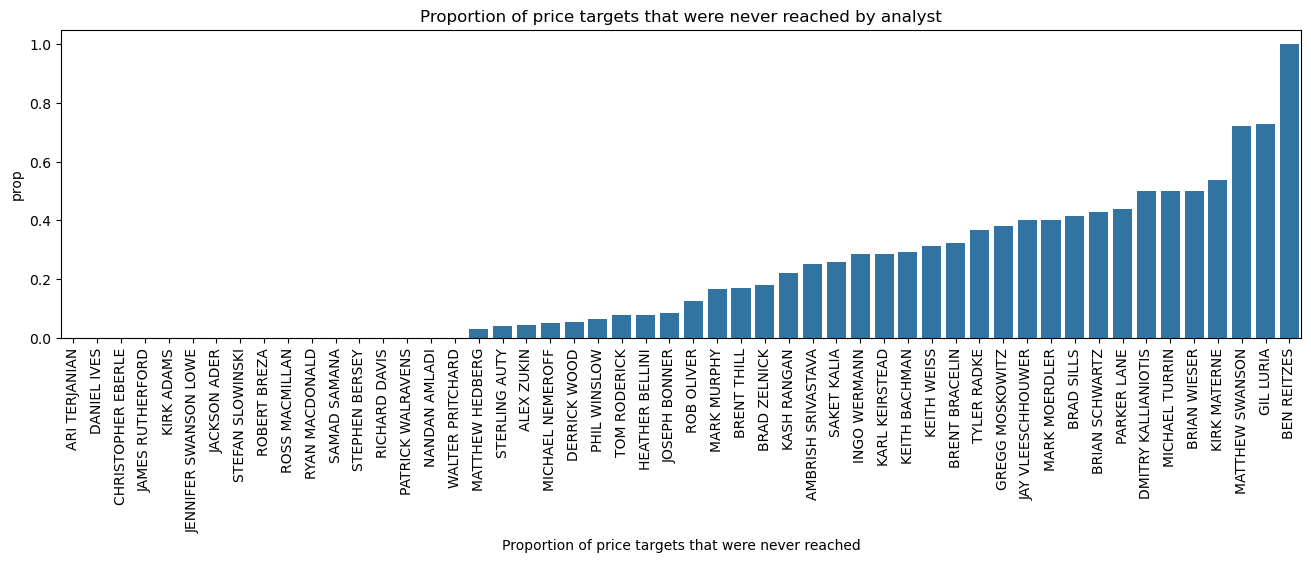

In [19]:
plt.figure(figsize=(16,4))
sns.barplot(never_hit_pt_sorted, x='analyst', y='prop')
plt.xticks(rotation=90)
plt.title('Proportion of price targets that were never reached by analyst')
plt.xlabel('Proportion of price targets that were never reached')
plt.show()

### Comparing the analysts who worked with Adobe stock to see who works with other tech companies' stocks 

To answer our research question about if the analysts that have the most experience with and background knowledge about tech companies, we decided to look at the total number of predictions that each analyst made for tech companies in the NASDAQ top 100. To do this, we queried from the Anachart data set every row that had a ticker that was for a tech company and downloaded it as a csv file. Then, we loaded that file into this notebook to make a data frame. We also cleaned that data frame by dropping all rows with a null value in the price target after column and fixed the typo in the name of the analyst column. 

In [20]:
tech_predictions = pd.read_csv('tech-predictions.csv')
tech_predictions = tech_predictions.rename(columns={'analytst':'analyst'})
tech_predictions = tech_predictions.dropna(subset=['price_target_after'])

### Making a function to compare the number of transactions with tech companies and make visualizations 

We decided that one of the best ways to see if making many predictions about tech companies was related to making better predictions was to randomly select some analysts from those that made predictions about adobe stock and then have visualizations that show how many predictions they've made about tech stocks, the proportion of their price targets for Adobe that were never hit, and a scatterplot of their average days to reach price target and average difference in price target and stock price when submitted. 

To do this, we made a function that will take a random sample of a specified number of rows from the main data frame that includes the features we want to visualize. Then, it adds a column to that data frame that represents the total number of tech predictions for each analyst. To do this, it makes a variable that holds a Pandas Series of the number of tech predictions made by each analyst by grouping the tech predictions data frame by analyst and getting the size for each analyst. Then it maps that series as a column in the main data frame that's inserted into the function, setting any null values to 0. Then, it makes 3 axes side-by-side in a figure, with the first being a bar chart of the total number of tech predictions for each randomly selected analyst, then a bar chart of the proportion of their Adobe price targets that were never hit, and finally a scatterplot with the average price target for Adobe stock on the x-axis and the average difference in price target and stock price on the y-axis. Some formatting is also applied to make the plots more readable.  

In [21]:
def random_analysts(merged, tech_predictions, n=5, seed=1234): 
    analysts = merged.sample(n=n, random_state=seed).copy()

    counts = (
        tech_predictions
        .groupby('analyst')
        .size()
    )

    analysts['total_predictions_all_companies'] = (
        analysts['analyst']
        .map(counts)
        .fillna(0)
        .astype(int)
    )

    fig, axes = plt.subplots(1, 3, figsize=(16.5,5.5))

    sns.barplot(
        data=analysts, 
        x='analyst', 
        y='total_predictions_all_companies', 
        ax=axes[0]
    )

    sns.barplot(
        data=analysts,
        x='analyst',
        y='prop',
        ax=axes[1]
    )

    sns.scatterplot(
        data=analysts,
        x='avg_days_to_target',
        y='avg_difference',
        hue='analyst',
        ax=axes[2]
    )

    axes[0].tick_params(axis='x', rotation=90)
    axes[1].tick_params(axis='x', rotation=90)
    axes[0].set_ylabel('Number of predictions for tech companies')
    axes[1].set_ylabel('Proportion of price target never hit')
    axes[2].set_xlabel('Avg number of days for price target to be reached')
    axes[2].set_ylabel('Avg difference between price target and stock price')
    plt.legend(bbox_to_anchor=(1.65,1))
    plt.tight_layout()
    plt.show()


The function described above is ran, specifying the seed and number of analysts we're selecting. 

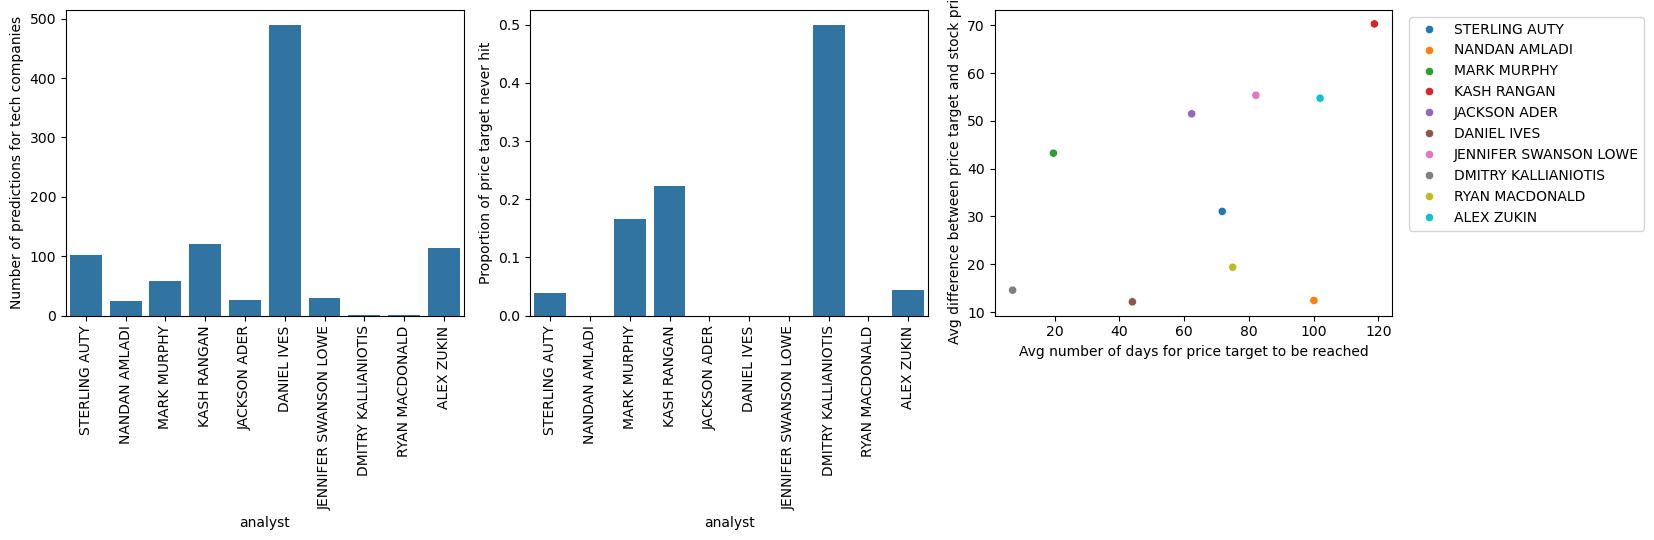

In [28]:
random_analysts(merged, tech_predictions, n=10, seed=123)

To make visualizations in Flourish, we also added the total predictions column to the merged data frame and downloaded it as a csv file. 

In [25]:
analysts = merged
counts = (tech_predictions.groupby('analyst').size())
analysts['total_predictions_all_companies'] = (analysts['analyst'].map(counts).fillna(0).astype(int))

In [27]:
analysts.to_csv('analysts-data-tech-companies', index=False)